In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('C://Users//demey//Documents//2024-2025//Industry Project//Bariatric Project Study Data 2025_mod.xlsx', sheet_name='Sheet1')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
import pandas as pd
import matplotlib.pyplot as plt

In [49]:
core_X_data=df[['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt','procedure_category','antibiotics','cholecystectomy_repair','hiatus_hernia_repair']].copy()
cm_cols= [col for col in df.columns if col.startswith('CM_')]

cm_data = df[cm_cols].fillna(0).astype(int)
cm_data
zero_only = [col for col in cm_data.columns if (cm_data[col] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# finally, join the filtered CM_ data back into your core set
core_X_data = core_X_data.join(cm_data)
core_X_data.fillna(0, inplace=True)
print(core_X_data.isna().sum())  # should all be zero   

# inspect result
print("Dropped CM columns:", zero_only)
print("Remaining columns in CM data:", cm_data.columns.tolist())
# 1) Grab all the antibiotic dummy columns
ab_cols = [c for c in core_X_data.columns if c.startswith('antibiotics')]

# 2) Count zeros in each column
for col in ab_cols:
    n_zeros = (core_X_data[col] == 0).sum()
    print(f"{col}: {n_zeros} zeros out of {len(core_X_data)} rows")

# 3) (Bonus) How many rows have *no* antibiotic flagged?
no_ab_rows = (core_X_data[ab_cols].sum(axis=1) == 0).sum()
print(f"\nRows where ALL antibiotic dummies are 0 (i.e. original 0): {no_ab_rows}")

gender                    0
age                       0
height                    0
weight                    0
bmi                       0
family_hist_cnt           0
chronic_meds_cnt          0
procedure_category        0
antibiotics               0
cholecystectomy_repair    0
hiatus_hernia_repair      0
CM_AIDS                   0
CM_ANEMDEF                0
CM_ARTH                   0
CM_CHF                    0
CM_DEPRESS                0
CM_DM                     0
CM_DMCX                   0
CM_HTN_C                  0
CM_HYPOTHY                0
CM_LIVER                  0
CM_OBESE                  0
CM_PSYCH                  0
CM_SMOKE                  0
CM_APNEA                  0
CM_CHOLSTRL               0
CM_OSTARTH                0
CM_HPLD                   0
dtype: int64
Dropped CM columns: ['CM_ALCOHOL', 'CM_BLDLOSS', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DRUG', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_PARA', 'CM_PERIVASC', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'C

In [50]:
core_X_data.shape

(344, 28)

In [51]:
# Identify all complication-related columns
comp_cols = [col for col in df.columns if 'comp' in col.lower()]

In [52]:
comp_cols

['post_op_complication',
 'days_30_complication',
 'days_30_plus_complication',
 'minor_complication',
 'major_complication',
 'minor_comp_month_1',
 'complications',
 'surgery_complication',
 'post_op_complication.1',
 'days_30_complication.1',
 'days_30_plus_complication.1']

In [53]:
complication_data = df[['minor_complication', 'major_complication']].copy()
complication_data.head(1000)

,minor_complication,major_complication
0,0,0
1,0,0
2,1,0
3,0,0
4,0,0
...,...,...
339,0,0
340,0,0
341,1,0
342,0,0


In [54]:
X = core_X_data.copy()
y_major = complication_data['major_complication']
y_minor = complication_data['minor_complication']

In [55]:
from sklearn.model_selection import train_test_split
# Handle categorical variables first
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_minor, test_size=0.2, random_state=42, stratify=y_minor
)

print("Class distribution in training set:")
print(f"No complications: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Complications: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"No complications: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"Complications: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
X_encoded.head()

Class distribution in training set:
No complications: 253 (92.0%)
Complications: 22 (8.0%)

Class distribution in test set:
No complications: 64 (92.8%)
Complications: 5 (7.2%)


,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,cholecystectomy_repair,hiatus_hernia_repair,CM_AIDS,CM_ANEMDEF,...,procedure_category_BPD -DS,procedure_category_Mini gastric bypass (OAGB),procedure_category_RYGBP,procedure_category_SADI,procedure_category_Sleeve,antibiotics_Augmentin,antibiotics_Clindamycin,antibiotics_Invanz,antibiotics_Kefsol,antibiotics_Rocephin
0,50,154,146.0,61.56,0,0,0,0,0,0,...,False,False,False,True,False,False,False,False,True,False
1,52,168,96.0,34.00,0,0,1,0,0,0,...,False,False,False,False,True,False,False,False,True,False
2,23,163,143.0,53.82,0,0,0,1,0,0,...,False,False,False,True,False,False,False,False,True,False
3,23,176,120.0,38.74,0,0,0,1,0,0,...,False,False,False,False,True,False,False,False,True,False
4,57,162,112.0,42.68,0,7,0,1,0,0,...,False,False,False,True,False,False,False,False,True,False


In [56]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# Train model
minor_model = RandomForestClassifier(random_state=42)
minor_model.fit(X_train, y_train)

# Evaluate
y_pred = minor_model.predict(X_test)
print("Minor Complication Report:")
print(classification_report(y_test, y_pred))


Minor Complication Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        64
           1       0.00      0.00      0.00         5

    accuracy                           0.90        69
   macro avg       0.46      0.48      0.47        69
weighted avg       0.86      0.90      0.88        69



In [57]:
X= X_encoded.copy()

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y_major, test_size=0.2, random_state=42)

major_model = RandomForestClassifier(random_state=42)
major_model.fit(X_train, y_train)

y_pred = major_model.predict(X_test)
print("Major Complication Report:")
print(classification_report(y_test, y_pred))


Major Complication Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        67
           1       0.00      0.00      0.00         2

    accuracy                           0.97        69
   macro avg       0.49      0.50      0.49        69
weighted avg       0.94      0.97      0.96        69



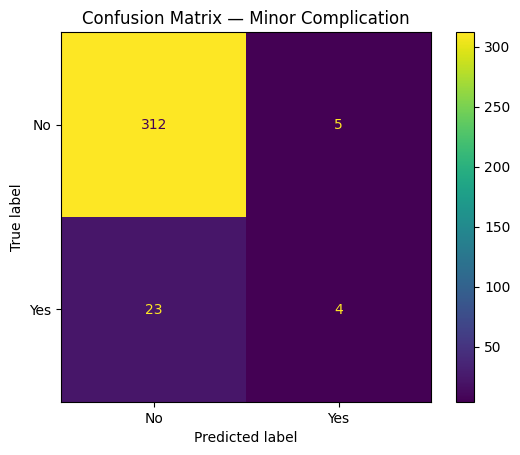

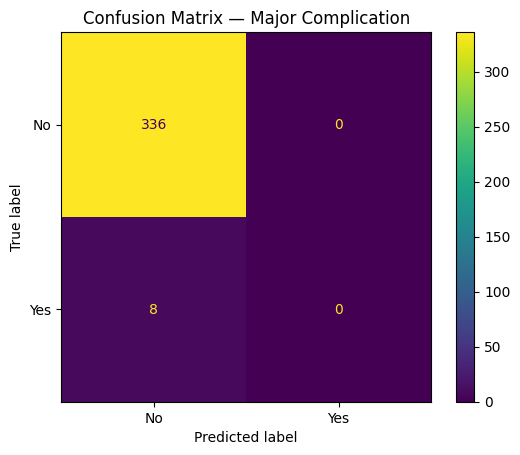


=== Minor Complication Metrics ===
              precision    recall  f1-score     support
0              0.931343  0.984227  0.957055  317.000000
1              0.444444  0.148148  0.222222   27.000000
accuracy       0.918605  0.918605  0.918605    0.918605
macro avg      0.687894  0.566188  0.589639  344.000000
weighted avg   0.893127  0.918605  0.899379  344.000000

=== Major Complication Metrics ===
              precision    recall  f1-score     support
0              0.976744  1.000000  0.988235  336.000000
1              0.000000  0.000000  0.000000    8.000000
accuracy       0.976744  0.976744  0.976744    0.976744
macro avg      0.488372  0.500000  0.494118  344.000000
weighted avg   0.954029  0.976744  0.965253  344.000000


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_predict

# if you’ve got imblearn:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline       import Pipeline

def cv_with_ros(X, y, title, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    pipe = Pipeline([
        ("ros", RandomOverSampler(random_state=42)),
        ("rf",  RandomForestClassifier(class_weight="balanced", random_state=42))
    ])

    # get out-of-fold predictions
    y_pred = cross_val_predict(pipe, X, y, cv=cv, method="predict")

    # plot confusion matrix
    cm   = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["No","Yes"])
    disp.plot()
    plt.title(f"Confusion Matrix — {title}")
    plt.show()

    # return report as DataFrame
    rpt = classification_report(y, y_pred, output_dict=True)
    return pd.DataFrame(rpt).transpose()

# run for both tasks
minor_report = cv_with_ros(X, y_minor, "Minor Complication")
major_report = cv_with_ros(X, y_major, "Major Complication")

print("\n=== Minor Complication Metrics ===")
print(minor_report[["precision","recall","f1-score","support"]])

print("\n=== Major Complication Metrics ===")
print(major_report[["precision","recall","f1-score","support"]])


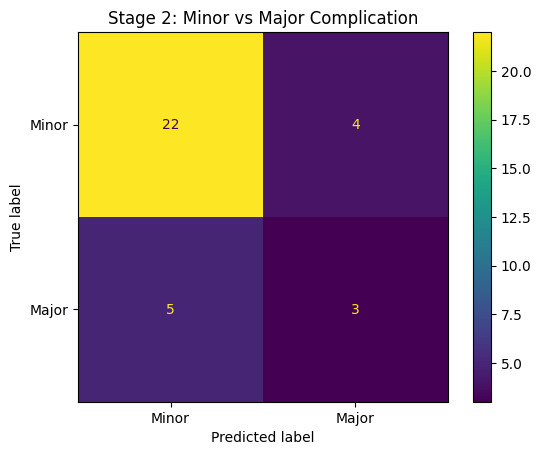

              precision    recall  f1-score   support

           0       0.81      0.85      0.83        26
           1       0.43      0.38      0.40         8

    accuracy                           0.74        34
   macro avg       0.62      0.61      0.62        34
weighted avg       0.72      0.74      0.73        34



In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold

# — ASSUMPTION: X, y_minor, y_major are already defined —
# X may be a pandas DataFrame or a numpy array
# y_minor, y_major are 1D arrays or Series of 0/1 labels

# 1) Build the “any complication” mask
y_any = ((y_minor == 1) | (y_major == 1)).astype(int)
mask  = (y_any == 1)

# 2) Subset to only complication cases
if isinstance(X, pd.DataFrame):
    X_comp = X.iloc[mask.values]
else:
    X_comp = X[mask]

y_type = np.asarray(y_major)[mask]   # 1=major, 0=minor

# 3) Manual oversampling + stratified CV
cv     = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred = np.zeros_like(y_type)

for train_idx, test_idx in cv.split(X_comp, y_type):
    # get train/test splits
    X_tr = X_comp.iloc[train_idx] if isinstance(X_comp, pd.DataFrame) else X_comp[train_idx]
    y_tr = y_type[train_idx]
    X_te = X_comp.iloc[test_idx]  if isinstance(X_comp, pd.DataFrame) else X_comp[test_idx]

    # manual random oversample minority class in the training fold
    classes, counts = np.unique(y_tr, return_counts=True)
    if len(classes) > 1:
        minor_cls = classes[np.argmin(counts)]
        idx_min   = np.where(y_tr == minor_cls)[0]
        n_extra   = counts.max() - counts.min()
        extra_idx = np.random.choice(idx_min, size=n_extra, replace=True)

        X_tr_bal = np.vstack([X_tr, X_tr[extra_idx]]) if not isinstance(X_tr, pd.DataFrame) else pd.concat([X_tr, X_tr.iloc[extra_idx]], ignore_index=True)
        y_tr_bal = np.concatenate([y_tr, y_tr[extra_idx]])
    else:
        X_tr_bal, y_tr_bal = X_tr, y_tr

    # train and predict
    clf = RandomForestClassifier(class_weight="balanced", random_state=42)
    clf.fit(X_tr_bal, y_tr_bal)
    y_pred[test_idx] = clf.predict(X_te)

# 4) Plot and report
cm = confusion_matrix(y_type, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Minor", "Major"])
disp.plot()
plt.title("Stage 2: Minor vs Major Complication")
plt.show()

report = classification_report(y_type, y_pred)
print(report)


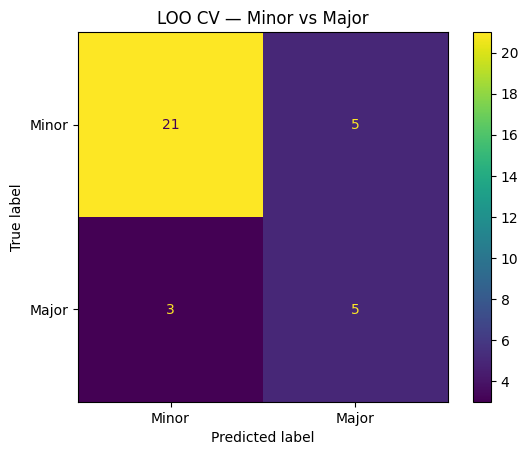

              precision    recall  f1-score   support

           0       0.88      0.81      0.84        26
           1       0.50      0.62      0.56         8

    accuracy                           0.76        34
   macro avg       0.69      0.72      0.70        34
weighted avg       0.79      0.76      0.77        34



In [61]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# — assume X_comp (34×F DataFrame or ndarray) and y_type (length-34 array) are defined —

loo    = LeaveOneOut()
y_pred = np.zeros_like(y_type)
y_prob = np.zeros_like(y_type, dtype=float)

for train_idx, test_idx in loo.split(X_comp):
    # 1) Proper slicing for DataFrame vs ndarray
    if hasattr(X_comp, "iloc"):
        X_tr = X_comp.iloc[train_idx]
        X_te = X_comp.iloc[test_idx]
    else:
        X_tr = X_comp[train_idx]
        X_te = X_comp[test_idx]
    
    y_tr = y_type[train_idx]

    # 2) (Re)train your simple model
    clf = LogisticRegression(
        penalty="l2", C=1.0,
        class_weight="balanced",
        solver="liblinear",
        random_state=42
    )
    clf.fit(X_tr, y_tr)

    # 3) Predict on the held-out sample
    y_pred[test_idx] = clf.predict(X_te)
    y_prob[test_idx] = clf.predict_proba(X_te)[:, 1]

# 4) Aggregate results
cm = confusion_matrix(y_type, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Minor","Major"])
disp.plot()
plt.title("LOO CV — Minor vs Major")
plt.show()

print(classification_report(y_type, y_pred))


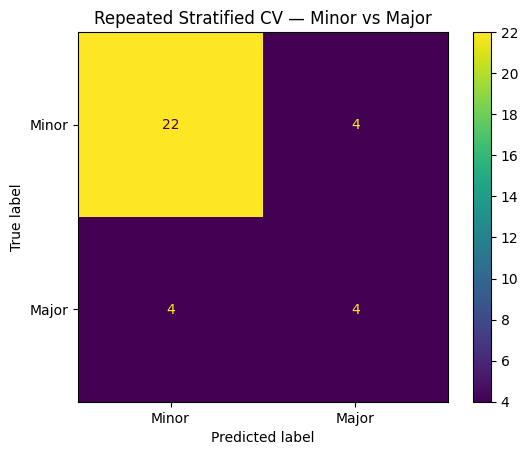

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        26
           1       0.50      0.50      0.50         8

    accuracy                           0.76        34
   macro avg       0.67      0.67      0.67        34
weighted avg       0.76      0.76      0.76        34

Brier score (major prob): 0.131


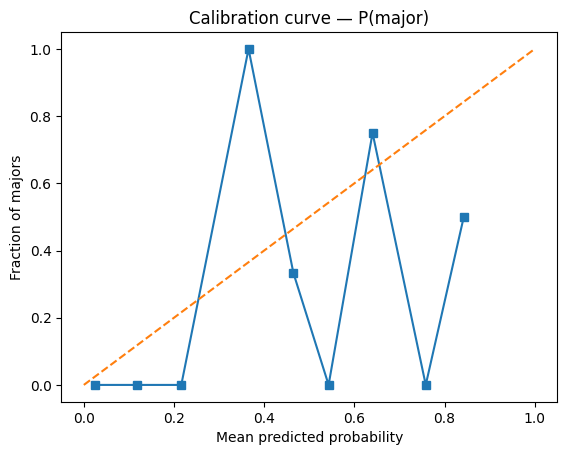

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model       import LogisticRegression
from sklearn.metrics            import confusion_matrix, ConfusionMatrixDisplay, classification_report, brier_score_loss
from sklearn.model_selection    import RepeatedStratifiedKFold
from sklearn.calibration        import CalibratedClassifierCV
from imblearn.over_sampling     import RandomOverSampler
from imblearn.pipeline          import Pipeline
from sklearn.base               import clone

# — assume X_comp (34×F array or DataFrame) and y_type (length-34 array) are defined —

# 1) Build & calibrate your base pipeline
base = Pipeline([
    ("ros", RandomOverSampler(random_state=42)),
    ("clf", LogisticRegression(
        penalty="l2",
        C=1.0,
        class_weight="balanced",
        solver="liblinear",
        random_state=42
    ))
])
# wrap for probability calibration
cal = CalibratedClassifierCV(base, cv=5, method="isotonic")

# 2) Prepare repeated stratified splits
rs = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# placeholders
y_probs  = np.zeros(len(y_type))
y_counts = np.zeros(len(y_type))
y_preds  = np.zeros(len(y_type), dtype=int)

# 3) Loop through folds, fit on TRAIN only, predict on TEST
for train_idx, test_idx in rs.split(X_comp, y_type):
    X_tr = X_comp.iloc[train_idx] if hasattr(X_comp, "iloc") else X_comp[train_idx]
    y_tr = y_type[train_idx]
    X_te = X_comp.iloc[test_idx]  if hasattr(X_comp, "iloc") else X_comp[test_idx]

    # fit a fresh calibrated model
    cal_fold = clone(cal)
    cal_fold.fit(X_tr, y_tr)
    
    # collect probabilities
    probs = cal_fold.predict_proba(X_te)[:,1]
    y_probs[test_idx] += probs
    y_counts[test_idx] += 1

# 4) Average probs & get final class predictions
y_probs /= y_counts
y_preds  = (y_probs >= 0.5).astype(int)

# 5) Confusion matrix + report
cm = confusion_matrix(y_type, y_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Minor","Major"])
disp.plot()
plt.title("Repeated Stratified CV — Minor vs Major")
plt.show()

print(classification_report(y_type, y_preds))

# 6) Calibration check
brier = brier_score_loss(y_type, y_probs)
print(f"Brier score (major prob): {brier:.3f}")

from sklearn.calibration import calibration_curve
frac_pos, mean_pred = calibration_curve(y_type, y_probs, n_bins=10)
plt.plot(mean_pred, frac_pos, "s-")
plt.plot([0,1],[0,1],"--")
plt.title("Calibration curve — P(major)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of majors")
plt.show()


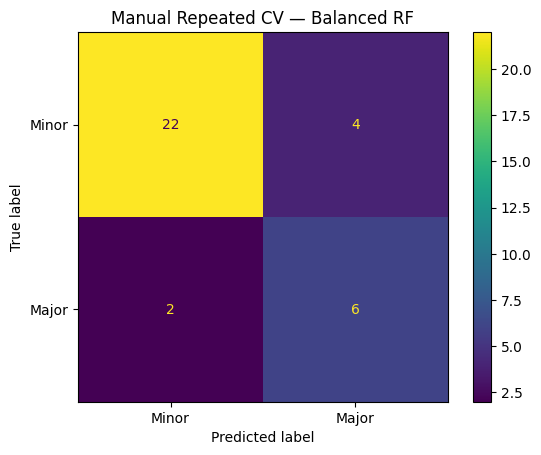

              precision    recall  f1-score   support

           0       0.92      0.85      0.88        26
           1       0.60      0.75      0.67         8

    accuracy                           0.82        34
   macro avg       0.76      0.80      0.77        34
weighted avg       0.84      0.82      0.83        34



In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics            import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection    import RepeatedStratifiedKFold
from sklearn.base               import clone
from imblearn.ensemble          import BalancedRandomForestClassifier

# — assume X_comp (34×F array or DataFrame) and y_type (length-34 0/1 array) are defined —

# 1) Define your balanced random forest
base_clf = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# 2) Set up repeated stratified splits
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# placeholders for accumulating
n_samples  = len(y_type)
vote_probs = np.zeros(n_samples)
vote_counts = np.zeros(n_samples)
vote_preds = np.zeros(n_samples, dtype=int)

# 3) Loop over each split, fit & predict
for train_idx, test_idx in rkf.split(X_comp, y_type):
    # extract training & test fold
    X_tr = X_comp.iloc[train_idx] if hasattr(X_comp, "iloc") else X_comp[train_idx]
    y_tr = y_type[train_idx]
    X_te = X_comp.iloc[test_idx]  if hasattr(X_comp, "iloc") else X_comp[test_idx]
    
    # clone the classifier so we start fresh each fold
    clf = clone(base_clf)
    clf.fit(X_tr, y_tr)
    
    # get probabilities and predictions on the test fold
    probs = clf.predict_proba(X_te)[:,1]
    preds = clf.predict(X_te)
    
    # accumulate
    vote_probs[test_idx]  += probs
    vote_counts[test_idx] += 1
    vote_preds[test_idx]  += preds

# 4) Compute averaged probability & majority vote prediction
avg_probs = vote_probs / vote_counts
final_preds = (avg_probs >= 0.5).astype(int)  # or keep avg_probs for risk scores

# 5) Confusion matrix & report
cm = confusion_matrix(y_type, final_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Minor","Major"])
disp.plot()
plt.title("Manual Repeated CV — Balanced RF")
plt.show()

print(classification_report(y_type, final_preds))


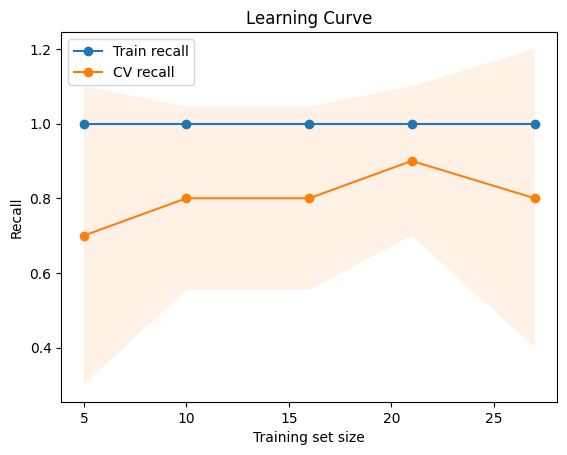

In [64]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

# clf = your classifier (e.g. BalancedRandomForestClassifier or LogisticRegression)
# X_comp, y_type = your 34×F data and labels

train_sizes, train_scores, test_scores = learning_curve(
    clf, X_comp, y_type,
    train_sizes=[0.2, 0.4, 0.6, 0.8, 1.0],
    cv=5,
    scoring="recall",
    n_jobs=-1
)

# Compute means & stds over folds
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores,  axis=1)
test_mean  = np.mean(test_scores,  axis=1)
test_std   = np.std(test_scores,   axis=1)

# Plot
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean-test_std,   test_mean+test_std,   alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', label='Train recall')
plt.plot(train_sizes, test_mean,  'o-', label='CV recall')
plt.xlabel('Training set size')
plt.ylabel('Recall')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()


In [65]:
from sklearn.ensemble        import BaggingClassifier
from sklearn.linear_model   import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

# 1) Base model: regularized logistic
base_clf = LogisticRegression(
    penalty="l2",
    C=0.1,
    class_weight="balanced",
    solver="liblinear",
    random_state=42
)

# 2) Bagging wrapper (use `estimator=` not `base_estimator=`)
bag_clf = BaggingClassifier(
    estimator=base_clf,
    n_estimators=100,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# 3) Evaluate with repeated stratified CV
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
scores = cross_val_score(bag_clf, X_comp, y_type, cv=cv, scoring="recall", n_jobs=-1)

print(f"Recall: {scores.mean():.2f} ± {scores.std():.2f}")


Recall: 0.64 ± 0.40


In [66]:
from joblib import load
model_any = load("backend/best_model_pipeline.pkl")

# Stage-2: major vs minor, bagged logistic
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

base_clf = LogisticRegression(
    penalty="l2", C=0.1, class_weight="balanced",
    solver="liblinear", random_state=42
)
model_type = BaggingClassifier(
    estimator=base_clf, n_estimators=100,
    bootstrap=True, random_state=42, n_jobs=-1
)
model_type.fit(X_comp, y_type)  # X_comp, y_type are your 34 complication cases


BaggingClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced',
                                               random_state=42,
                                               solver='liblinear'),
                  n_estimators=100, n_jobs=-1, random_state=42)

In [67]:
import random
import numpy as np

# — assume you’ve already loaded df, X, y_minor, y_major —
# — and trained:
#     model_any   : predicts P(any complication)
#     model_type  : predicts P(major | complication) on X_comp/y_type

# 1) Pick a random patient index
idx = random.choice(df.index.tolist())

# 2) Extract their features for prediction
#    keep as a 2D array / DataFrame slice
x_new = X.loc[[idx]] if hasattr(X, "loc") else X[np.newaxis, idx]

# 3) Stage 1: P(any complication)
p_any = model_any.predict_proba(x_new)[0, 1]

# 4) Stage 2: P(major | complication)
#    if you only trained model_type on complication cases,
#    you might want to guard—but here we just call it
p_given = model_type.predict_proba(x_new)[0, 1]

# 5) Joint probabilities
p_major = p_any * p_given
p_minor = p_any * (1 - p_given)

# 6) Reveal predictions and the true outcome
true_minor = y_minor[idx]
true_major = y_major[idx]

print(f"Random patient index: {idx}")
print("Features:", x_new.to_dict(orient="records")[0])
print(f"P(any complication) = {p_any:.3f}")
print(f"P(major | complication) = {p_given:.3f}")
print(f"→ P(major) = {p_major:.3f}, P(minor) = {p_minor:.3f}")
print(f"True outcome: minor_complication = {true_minor}, major_complication = {true_major}")


Random patient index: 268
Features: {'age': 35, 'height': 158, 'weight': 131.0, 'bmi': 52.48, 'family_hist_cnt': 0, 'chronic_meds_cnt': 0, 'cholecystectomy_repair': 0, 'hiatus_hernia_repair': 0, 'CM_AIDS': 0, 'CM_ANEMDEF': 0, 'CM_ARTH': 0, 'CM_CHF': 0, 'CM_DEPRESS': 0, 'CM_DM': 1, 'CM_DMCX': 1, 'CM_HTN_C': 1, 'CM_HYPOTHY': 0, 'CM_LIVER': 0, 'CM_OBESE': 1, 'CM_PSYCH': 0, 'CM_SMOKE': 0, 'CM_APNEA': 0, 'CM_CHOLSTRL': 1, 'CM_OSTARTH': 1, 'CM_HPLD': 1, 'gender_Male': False, 'procedure_category_BPD -DS': False, 'procedure_category_Mini gastric bypass (OAGB)': False, 'procedure_category_RYGBP': True, 'procedure_category_SADI': False, 'procedure_category_Sleeve': False, 'antibiotics_Augmentin': True, 'antibiotics_Clindamycin': False, 'antibiotics_Invanz': False, 'antibiotics_Kefsol': False, 'antibiotics_Rocephin': False}
P(any complication) = 0.088
P(major | complication) = 0.481
→ P(major) = 0.042, P(minor) = 0.046
True outcome: minor_complication = 0, major_complication = 0
